## Data reading and Data Insights

**Playing Strategy Games: appulb9e, 16 days participation**

*Dataset:* 'Playing Strategy Games' vs 'Not Playing Strategy Games' study

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az

In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_playing_strategy_games_-_appulb9e_2025-04-24 17_52_59.293//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_playing_strategy_games_-_appulb9e_2025-04-24 17_52_59.293//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: appulb9e
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: 'a12d5355-12e4-436c-b424-cf697c9a6cf0'


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  a12d5355-12e4-436c-b424-cf697c9a6cf0                  16


As anticipated, the study comprised a single participant, with a total participation period of 16 days.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),           
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a12d5355-12e4-436c-b424-cf697c9a6cf0 ---

  Outcome:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0


The participant consistently took part in the study every day over the 16-day period.

#### Remove Participants Who Joined Outside the Study

In [7]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-04-23 19:43:00.861733+00:00,Mediators,a12d5355-12e4-436c-b424-cf697c9a6cf0,15,Playing strategy games!,NaN,NaN,NaN,NaN,6.0,6.0


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
31,2025-04-08 21:21:48.079299+00:00,Outcome,a12d5355-12e4-436c-b424-cf697c9a6cf0,0,Playing strategy games!,3.0,3.0,7.0,1.0,NaN,NaN
29,2025-04-09 19:28:47.890115+00:00,Outcome,a12d5355-12e4-436c-b424-cf697c9a6cf0,1,Playing strategy games!,2.0,2.0,5.0,1.0,NaN,NaN
27,2025-04-10 20:02:37.743605+00:00,Outcome,a12d5355-12e4-436c-b424-cf697c9a6cf0,2,Playing strategy games!,6.0,7.0,7.0,1.0,NaN,NaN
25,2025-04-11 19:19:52.777438+00:00,Outcome,a12d5355-12e4-436c-b424-cf697c9a6cf0,3,Playing strategy games!,8.0,5.0,4.0,1.0,NaN,NaN
23,2025-04-12 21:05:46.585164+00:00,Outcome,a12d5355-12e4-436c-b424-cf697c9a6cf0,4,Avoid playing strategy games!,7.0,5.0,1.0,1.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)    

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 16
Columns: 11


#### Data types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),     
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a12d5355-12e4-436c-b424-cf697c9a6cf0 ---

  Outcome:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question4_re

#### Missing Values for Confirmations between 08.00 - 21.00

In [15]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 16 days have participation confirmations; no missing days found.


#### Summary Statistics

In [16]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             16.000000                   16.000000   
mean               7.500000                    4.937500   
std                4.760952                    1.730848   
min                0.000000                    2.000000   
25%                3.750000                    3.750000   
50%                7.500000                    5.000000   
75%               11.250000                    6.000000   
max               15.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   16.000000                   16.000000   
mean                     4.812500                    4.125000   
std                      1.759498                    3.095696   
min                      2.000000                    1.000000   
25%                      3.000000                    1.000000   
50%                      5.000000               

In [17]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 31 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            16 non-null     datetime64[ns, UTC]
 1   measurement_name            16 non-null     object             
 2   participant_id              16 non-null     object             
 3   current_day_of_study        16 non-null     int64              
 4   current_intervention_name   16 non-null     object             
 5   survey1_question1_response  16 non-null     float64            
 6   survey1_question2_response  16 non-null     float64            
 7   survey1_question3_response  16 non-null     float64            
 8   survey1_question4_response  16 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

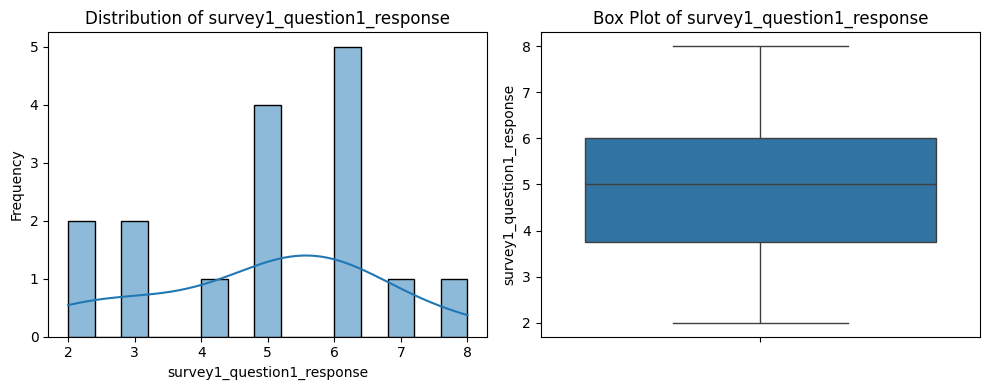

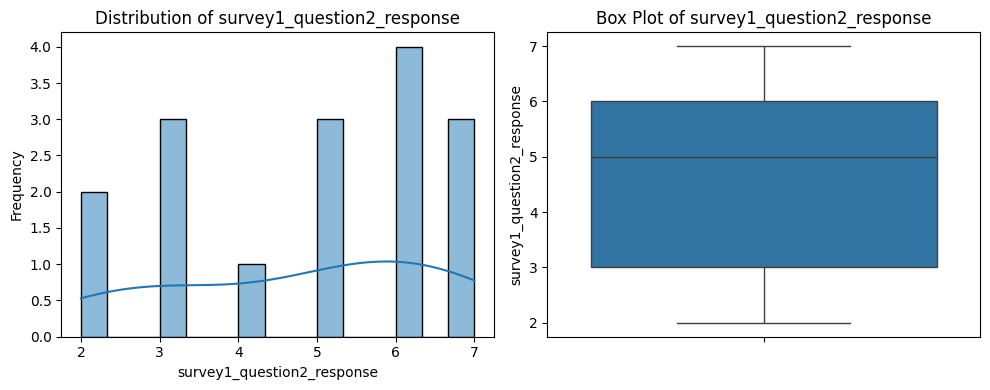

In [18]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

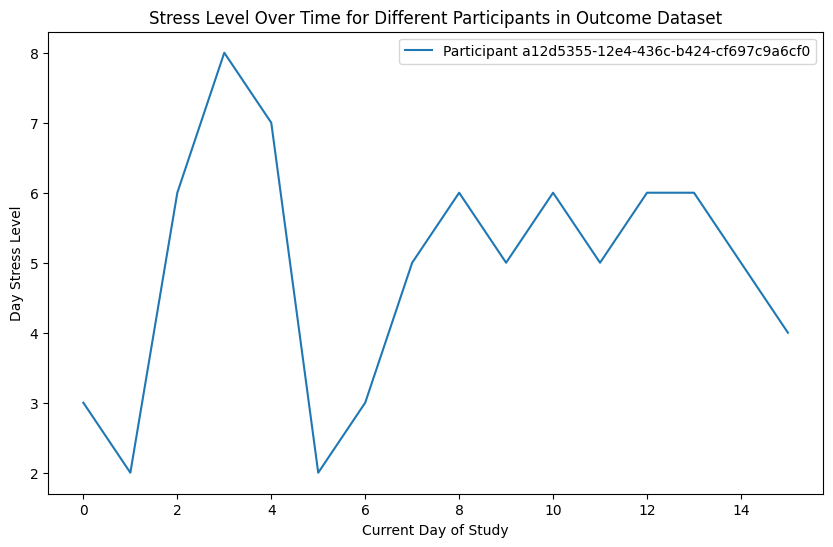

In [19]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

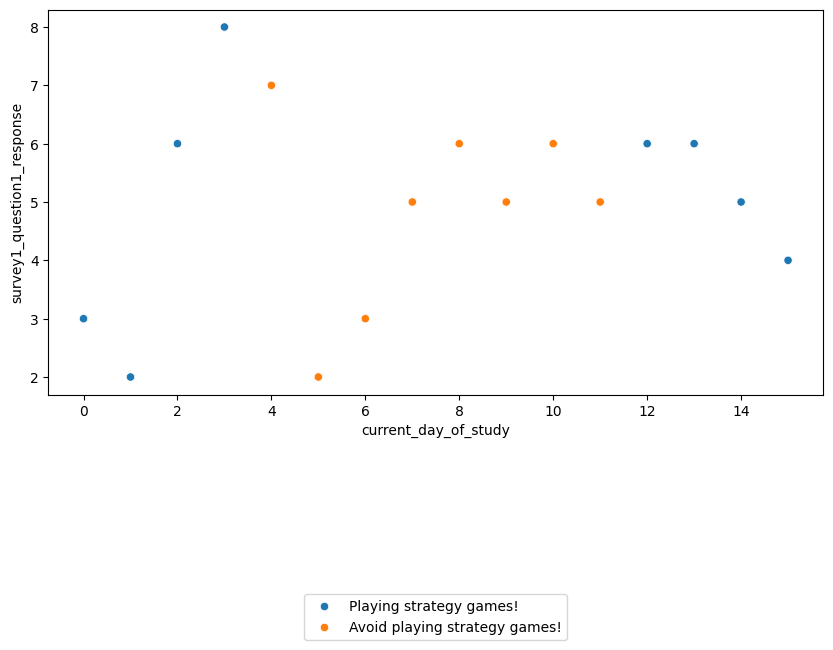

In [20]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

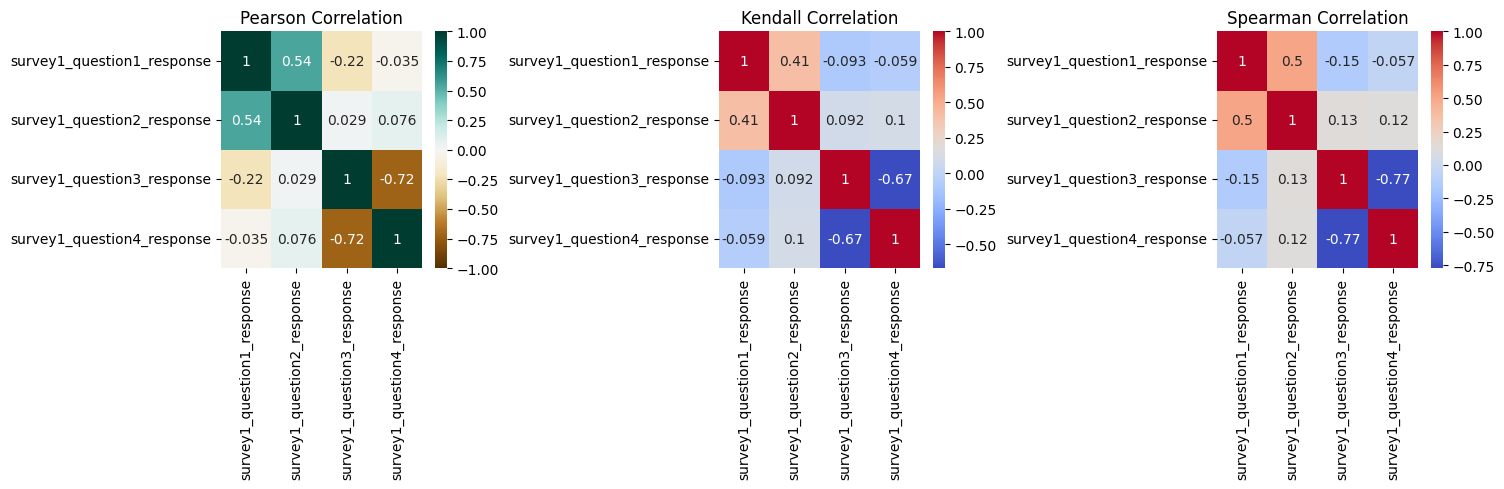

In [21]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Playing strategy games vs Avoid playing strategy games

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Playing strategy games!",
        "Avoid playing strategy games!"
    ])
]

playing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Playing strategy games!",
    'survey1_question1_response'
]
avoid = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid playing strategy games!",
    'survey1_question1_response'
]

n_playing   = playing.count()
n_avoid     = avoid.count()
std_playing = playing.std(ddof=1)
std_avoid   = avoid.std(ddof=1)

print(f"Playing strategy games:       n = {n_playing}, std = {std_playing:.2f}, mean = {playing.mean():.2f}")
print(f"Avoid strategy games:        n = {n_avoid}, std = {std_avoid:.2f}, mean = {avoid.mean():.2f}\n")



Playing strategy games:       n = 8, std = 1.93, mean = 5.00
Avoid strategy games:        n = 8, std = 1.64, mean = 4.88



#### Examination of outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Playing strategy games!",
        "Avoid playing strategy games!"
    ])
]

playing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Playing strategy games!",
    'survey1_question2_response'
]
avoid = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid playing strategy games!",
    'survey1_question2_response'
]

n_playing   = playing.count()
n_avoid     = avoid.count()
std_playing = playing.std(ddof=1)
std_avoid   = avoid.std(ddof=1)

print(f"Playing strategy games:       n = {n_playing}, std = {std_playing:.2f}, mean = {playing.mean():.2f}")
print(f"Avoid strategy games:        n = {n_avoid}, std = {std_avoid:.2f}, mean = {avoid.mean():.2f}\n")

Playing strategy games:       n = 8, std = 1.96, mean = 4.88
Avoid strategy games:        n = 8, std = 1.67, mean = 4.75



#### Examination of Outcomes: Mean Stress-Relief Score for Playing Strategy Games (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much playing strategy games alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'How much did this method (<i>playing strategy games</i>) help you today? <b>(Answer ONLY if you have played strategy games!)</b>'

In [25]:
# 'How much did this method (playing strategy games) help you today? (Answer ONLY if you have played strategy games!)'
mean_q3_game = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Playing strategy games!",
    'survey1_question3_response'
].mean()
mean_q3_game.item()

6.625

**Mean Stress-Relief Score for Strategy Games (Q3): 6.625**
On days when the participant played strategy games, he rated Question 3—“How much did this method (playing strategy games) help you today?”—an average of 6.625 out of 10, indicating a moderate benefit in reducing stress.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Strategy Games (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not play strategy games.

In [26]:
df_mea.survey1_question4_text[0]

'Did you have difficulty without the method (<i>not playing strategy games</i>)? <b>(Answer ONLY when playing strategy games is NOT practiced!)</b>'

In [27]:
# 'Did you have difficulty without the method (not playing strategy games)? (Answer ONLY when playing strategy games is NOT practiced!)'
mean_q4_no_game = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Avoid playing strategy games!",
    'survey1_question4_response'
].mean()
mean_q4_no_game.item()

4.375

**Mean Stress-Management Difficulty Score Without Strategy Games (Q4): 4.375**
On days when the participant skipped playing strategy games, he rated Question 4—“Did you have difficulty without the method (not playing strategy games)?”—an average of 4.375 out of 10, suggesting he experienced relatively low difficulty managing stress without this activity.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Playing strategy games!", "Avoid playing strategy games!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Playing strategy games!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.001
Model:                                    OLS   Adj. R-squared:                 -0.070
Method:                         Least Squares   F-statistic:                   0.01950
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.891
Time:                                12:35:47   Log-Likelihood:                -30.953
No. Observations:                          16   AIC:                             65.91
Df Residuals:                              14   BIC:                             67.45
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [29]:
# GLSAR Regression with AR(1) errors (Feasible GLS) 
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.025
Model:                                  GLSAR   Adj. R-squared:                 -0.050
Method:                         Least Squares   F-statistic:                    0.3273
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.577
Time:                                12:35:47   Log-Likelihood:                -27.895
No. Observations:                          15   AIC:                             59.79
Df Residuals:                              13   BIC:                             61.21
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Playing Strategy Games and Mediators

In [30]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Playing strategy games!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of playing strategy games ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 156 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.144  0.73    -1.243      1.587      0.029    0.022     631.0   
rho       0.452  0.27    -0.010      0.994      0.014    0.010     375.0   
sigma     1.720  0.30     1.201      2.362      0.011    0.013     750.0   

          ess_tail  r_hat  
beta_int     725.0   1.00  
rho          250.0   1.01  
sigma        417.0   1.01  
P(beta_int ≤ –0.5) = 18.90%
P(–0.5 < beta_int < 0) = 23.00%
P(beta_int ≥ 0) = 58.10%
P(Stress reduction of playing strategy games ≥ 0.5) = 18.90%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 444 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.124  0.752    -1.193      1.642      0.030    0.025     627.0   
beta_f1   0.413  0.377    -0.372      1.081      0.020    0.016     379.0   
rho       0.497  0.250     0.051      0.979      0.013    0.007     329.0   
sigma     1.678  0.296     1.160      2.285      0.011    0.011     742.0   

          ess_tail  r_hat  
beta_int     611.0   1.00  
beta_f1      386.0   1.00  
rho          346.0   1.01  
sigma        483.0   1.00  
P(beta_int ≤ –0.5) = 19.80%
P(–0.5 < beta_int < 0) = 22.40%
P(beta_int ≥ 0) = 57.80%
P(Stress reduction of playing strategy games ≥ 0.5) = 19.80%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 336 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.037  0.667    -1.303      1.252      0.026    0.021     656.0   
beta_f2   0.564  0.229     0.085      0.994      0.011    0.008     425.0   
rho       0.305  0.277    -0.178      0.890      0.012    0.013     538.0   
sigma     1.472  0.255     1.017      1.975      0.010    0.010     629.0   

          ess_tail  r_hat  
beta_int     628.0   1.01  
beta_f2      496.0   1.00  
rho          266.0   1.00  
sigma        552.0   1.00  
P(beta_int ≤ –0.5) = 20.90%
P(–0.5 < beta_int < 0) = 28.50%
P(beta_int ≥ 0) = 50.60%
P(Stress reduction of playing strategy games ≥ 0.5) = 20.90%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 393 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.027  0.728    -1.426      1.405      0.028    0.030     683.0   
beta_f1   0.170  0.435    -0.621      1.073      0.022    0.016     396.0   
beta_f2   0.512  0.249     0.056      1.000      0.011    0.008     558.0   
rho       0.365  0.296    -0.219      0.892      0.014    0.009     440.0   
sigma     1.535  0.274     1.003      2.041      0.012    0.009     440.0   

          ess_tail  r_hat  
beta_int     464.0   1.00  
beta_f1      498.0   1.01  
beta_f2      534.0   1.00  
rho          509.0   1.00  
sigma        317.0   1.00  
P(beta_int ≤ –0.5) = 22.30%
P(–0.5 < beta_int < 0) = 26.30%
P(beta_int ≥ 0) = 51.40%
P(Stress reduction of playing strategy games ≥ 0.5) = 22.30%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 244 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.664  1.084    -1.503      2.791      0.052    0.044     431.0   
rho       0.557  0.277     0.083      0.993      0.013    0.007     407.0   
sigma     1.898  0.402     1.264      2.720      0.019    0.019     456.0   

          ess_tail  r_hat  
beta_int     519.0   1.01  
rho          401.0   1.00  
sigma        519.0   1.00  
P(beta_int ≤ –0.5) = 12.80%
P(–0.5 < beta_int < 0) = 14.20%
P(beta_int ≥ 0) = 73.00%


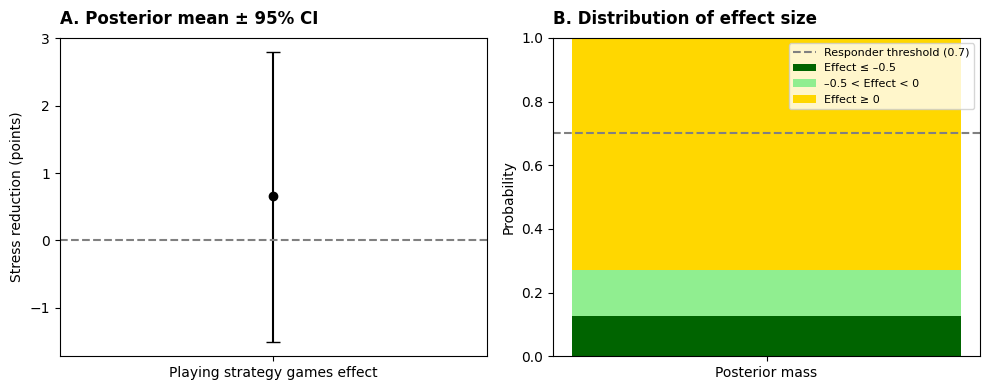

In [32]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == "Playing strategy games!").astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.0)

with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)        

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Playing strategy games effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()